# Insurance Claim Features and Model Clarify

In this notbook:
- load data from feature store
- building training set from FS
- build Pure Premium Modeling using AWS xgboost algo
- Run SageMaker Clarify processing job

What we can predict in this dataset?
1. __Claim Amount:__ total claims amount per policy holder.
1. __Claim Frequency:__ Number of claims per policy holder per exposure unit `Claim Frequency = Claim Count / Exposure`.
1. __Claim Severity:__ the average claim amount per claim for each policy holder per exposure unit `Claim Severity = Claim Cost / Claim Frequency`.
1. __Avg Claim amount:__ `Avg Claim amount = Claim Amount / Claim Count`
1. __Loss Cost:__ `Loss Cost = Claim Frequency x Claim Severity`
1. __Pure Premium:__ the mean of the total claim amount per exposure unit (the average loss per exposure) `PurePremium  = Claim Amount / Exposure`.

In [109]:
# !conda update scikit-learn -y
!pip install -U scikit-learn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (0.24.2)


In [110]:
%store -r global_variable
global_variable

'string or data-table to pass'

In [111]:
import sklearn
sklearn.__version__ 

'0.22.1'

In [112]:
print(__doc__)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

Automatically created module for IPython interactive environment


In [113]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

#### Retreive dataset from FeatureStores

Set the default s3 bucket name and it will be referenced throughout the notebook.

In [114]:
feature_store_session.default_bucket()

'sagemaker-ca-central-1-314997521033'

In [115]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-insurance'

print(default_s3_bucket_name)

sagemaker-ca-central-1-314997521033


In [116]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print (role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20201209T151511 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::314997521033:role/service-role/AmazonSageMaker-ExecutionRole-20201209T151511


In [117]:
!aws s3 ls s3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-06-20-23-32/

Now let's wait for the data to appear in our offline store before moving forward to creating a dataset. This will take approximately 5 minutes.

In [118]:
list_of_FG =sagemaker_client.list_feature_groups()
insurance_policy_feature_group_name = list_of_FG['FeatureGroupSummaries'][-1]['FeatureGroupName']
insurance_policy_feature_group_name

'insurance-policy-feature-group-12-02-46-09'

In [119]:
from sagemaker.feature_store.feature_group import FeatureGroup

insurance_policy_feature_group = FeatureGroup(name=insurance_policy_feature_group_name, sagemaker_session=feature_store_session)

In [120]:
account_id = boto3.client('sts').get_caller_identity()["Account"]
print(account_id)

insurance_policy_feature_group_s3_prefix = prefix + '/' + account_id + '/sagemaker/' + region + '/offline-store/' + insurance_policy_feature_group_name + '/data'
print(insurance_policy_feature_group_s3_prefix)

314997521033
sagemaker-featurestore-insurance/314997521033/sagemaker/ca-central-1/offline-store/insurance-policy-feature-group-12-02-46-09/data


## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [121]:
insurance_policy_query = insurance_policy_feature_group.athena_query()

insurance_policy_table = insurance_policy_query.table_name

query_string = 'SELECT * FROM "'+insurance_policy_table+'"' #+insurance_policy_table
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
insurance_policy_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
insurance_policy_query.wait()
dataset = insurance_policy_query.as_dataframe()

dataset

Running SELECT * FROM "insurance-policy-feature-group-12-02-46-09-1618195575"


,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.15,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.49,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.00,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.41,95.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.00,50.0,75.32,75.32,1.0,75.32,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.00,50.0,0.00,0.00,0.0,0.00,1.618196e+09,2021-04-12 02:47:42.963,2021-04-12 02:47:42.000,False
179996,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.00,56.0,0.00,0.00,0.0,0.00,1.618196e+09,2021-04-12 02:47:42.963,2021-04-12 02:47:42.000,False
179997,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.16,90.0,0.00,0.00,0.0,0.00,1.618196e+09,2021-04-12 02:47:42.963,2021-04-12 02:47:42.000,False
179998,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.08,61.0,0.00,0.00,0.0,0.00,1.618196e+09,2021-04-12 02:47:42.963,2021-04-12 02:47:42.000,False


In [122]:
# Prepare query results for training.
query_execution = insurance_policy_query.get_query_execution()
query_result = 's3://'+default_s3_bucket_name+'/'+prefix+'/query_results/'+query_execution['QueryExecution']['QueryExecutionId']+'.csv'
print(query_result)

s3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/query_results/8fc25168-72a2-4e46-92bd-01eab57e1ffb.csv


In [123]:
#!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/

In [124]:
df_features = pd.read_csv(query_result)

In [125]:
df_features.head()

,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.15,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.49,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.00,50.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.41,95.0,0.00,0.00,0.0,0.00,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.00,50.0,75.32,75.32,1.0,75.32,1.618274e+09,2021-04-13 00:39:32.596,2021-04-13 00:39:08.000,False


In [126]:
s3_client = boto3.client('s3', region_name=region)


In [127]:
#df_features.columns = feature_names +['PurePremium','Frequency','AvgClaimAmount','eventtime','write_time','api_invocation_time','is_deleted']

In [128]:
# Select useful columns for training with target column as the first.
dataset = df_features.iloc[:,np.r_[df_features.columns.get_loc('purepremium'), 0:60]]

# Write to csv in S3 without headers and index column.
dataset.to_csv('dataset.csv', header=False, index=False)
s3_client.upload_file('dataset.csv', default_s3_bucket_name, prefix+'/training_input/dataset.csv')
dataset_uri_prefix = 's3://'+default_s3_bucket_name+'/'+prefix+'/training_input/';

dataset

,purepremium,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,...,region_r91,region_r93,region_r94,area_a,area_b,area_c,area_d,area_e,area_f,density
0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.101701
1,0.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.868515
2,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.738619
3,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.339398
4,75.32,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.738619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,0.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.852927
179996,0.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.494344
179997,0.00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.100507
179998,0.00,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.557605


In [129]:
dataset.head()

,purepremium,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,...,region_r91,region_r93,region_r94,area_a,area_b,area_c,area_d,area_e,area_f,density
0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.101701
1,0.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.868515
2,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.738619
3,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.339398
4,75.32,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.738619


# Pure Premium Modeling

#### Pure Premium Modeling using xgboost

In [29]:
training_image=sagemaker.image_uris.retrieve("xgboost", region, "1.0-1")
training_image

'341280168497.dkr.ecr.ca-central-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

Retrieve model path

In [130]:
%store -r MODEL_PATH
MODEL_PATH

's3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/training_output/sagemaker-xgboost-2021-05-15-02-17-55-910/output/model.tar.gz'

Load XGBoost model from S3

In [132]:
trainnig_model = sagemaker.model.Model(
    model_data=MODEL_PATH,
    image_uri=training_image,
    role=role
)

In [ ]:
predictor = training_model.deploy(model_name='xgboost-insurance-model', initial_instance_count = 1, instance_type = 'ml.m5.xlarge')

Using already existing model: xgboost-insurance-model


------------

# Dectect Posttraining Data nad Model Bias

In [45]:
sagemaker_session = sagemaker.Session()
clarify_prefix = 'sagemaker_clarify'

After you have trained your model, instantiate the SageMaker Clarify processor using the following command:

In [46]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=sagemaker_session)

Next, configure the input dataset, where to store the output, the label column targeted with a DataConfig object, specify information about your trained model with ModelConfig, and provide information about the formats of your predictions with ModelPredictedLabelConfig.

A `ModelConfig` object communicates information about your trained model. To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing.
* `instance_type` and `instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify's processing. The testing dataset is small so a single standard instance is good enough to run this example. If your have a large complex dataset, you may want to use a better instance type to speed up, or add more instances to enable Spark parallelization.
* `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint.

In [47]:
dataset_path = f"s3://{default_s3_bucket_name}/sagemaker-featurestore-insurance/training_input/dataset.csv"
analysis_result_path = f"s3://{default_s3_bucket_name}/{clarify_prefix}/output"

bias_data_config = clarify.DataConfig(s3_data_input_path=dataset_path,
                                      s3_output_path=analysis_result_path,
                                      label='purepremium',
                                      headers=dataset.columns.to_list(),
                                      dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name="xgboost-insurance-model",
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

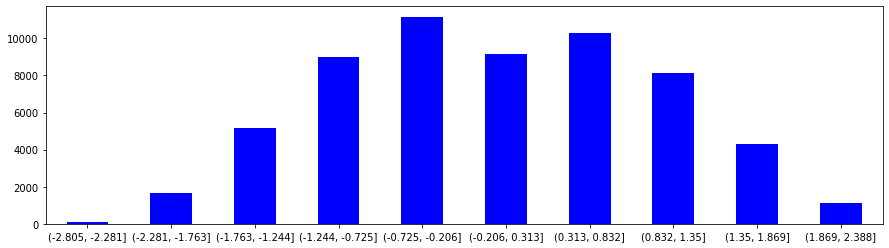

In [51]:
bins = pd.cut(dataset["density"],10)
ax = bins.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(15,4))
plt.show()

#### Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
SageMaker Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

In [49]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='density',
                                facet_values_or_threshold=[0.832])

In [50]:
clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')


Job Name:  Clarify-Bias-2021-05-09-02-36-59-131
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/training_input/dataset.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
................................

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Kernel SHAP algorithm requires a baseline (also known as background dataset). Baseline dataset type shall be the same as `dataset_type` of `DataConfig`, and baseline samples shall only include features. By definition, `baseline` should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the first sample of the test dataset to the list.

In [100]:
shap_config = clarify.SHAPConfig(baseline=[dataset.iloc[0,:60].values.tolist()],
                                 num_samples=60,
                                 agg_method='mean_abs',
                                 save_local_shap_values=True)

dataset_path = f"s3://{default_s3_bucket_name}/sagemaker-featurestore-insurance/training_input/dataset.csv"
explainability_output_path = f"s3://{default_s3_bucket_name}/{clarify_prefix}/output"
explainability_data_config = clarify.DataConfig(s3_data_input_path=dataset_path,
                                                s3_output_path=explainability_output_path,
                                                label='purepremium',
                                                headers=dataset.columns.to_list(),
                                                dataset_type='text/csv')

In [101]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-05-10-02-10-17-391
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/training_input/dataset.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
......................

#### Analysis of local explanations
It is possible to visualize the the local explanations for single examples in your dataset. You can use the obtained results from running Kernel SHAP algorithm for global explanations.

You can simply load the local explanations stored in your output path, and visualize the explanation (i.e., the impact that the single features have on the prediction of your model) for any single example.

Example number: 111 
with model prediction: True

Feature values -- Label purepremium             0.000000
vehage_bin0_0_4_0       0.000000
vehage_bin4_0_10_0      0.000000
vehage_bin10_0_100_0    1.000000
drivage_bin18_0_36_0    0.000000
                          ...   
area_c                  0.000000
area_d                  1.000000
area_e                  0.000000
area_f                  0.000000
density                 0.279562
Name: 111, Length: 61, dtype: float64


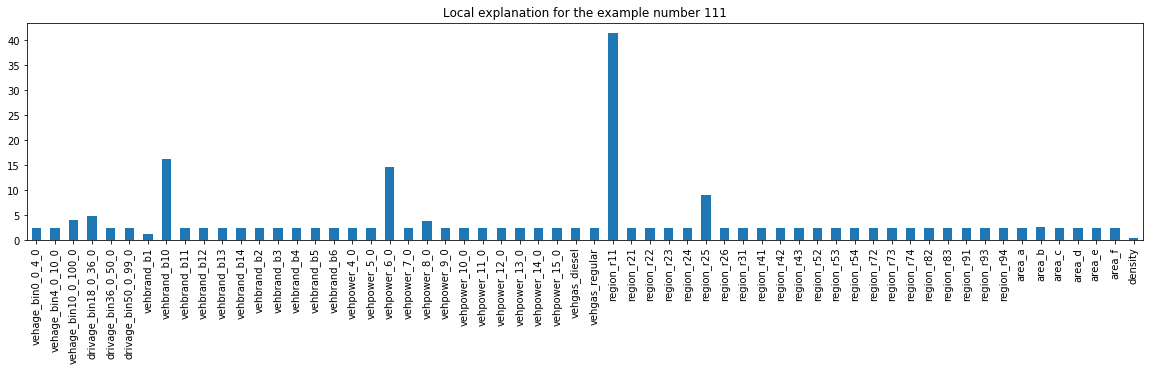

In [106]:
local_explanations_out = pd.read_csv(explainability_output_path+'/explanations_shap/out.csv')
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print("Example number:", selected_example, "\nwith model prediction:", sum(local_explanations_out.iloc[selected_example]) > 0)
print("\nFeature values -- Label", dataset.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(kind='bar', title='Local explanation for the example number '+str(selected_example), rot=90, figsize=(20,4))

#### Cleanup. Delete SageMaker Endpoint.

In [ ]:
sagemaker_client.delete_endpoint(EndpointName=predictor.endpoint_name)